# Predicting Fare of Airline Tickets using Machine Learning

- We're going to perform regression to predict airline fare tickets

In [21]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from warnings import filterwarnings
filterwarnings("ignore")
import plotly
import cufflinks as cf
from cufflinks.offline import go_offline
from plotly.offline import plot , iplot , init_notebook_mode , download_plotlyjs
init_notebook_mode(connected=True)
cf.go_offline()

In [24]:
# Functions

def change_into_Datetime(col):
    train_df[col] = pd.to_datetime(train_df[col])
    
def extract_hour_min(df , col):
    df[col+"_hour"] = df[col].dt.hour
    df[col+"_minute"] = df[col].dt.minute
    return df

def flight_dep_time(x):
    
    if (x>4) and (x<=8):
        return "Early Morning"
    
    elif (x>8) and (x<=12):
        return "Morning"
    
    elif (x>12) and (x<=16):
        return "Noon"
    
    elif (x>16) and (x<=20):
        return "Evening"
    
    elif (x>20) and (x<=24):
        return "Night"
    
    else:
        return "Late Night"

def preprocess_duration(x):
    
    if 'h' not in x:
        x = '0h' + ' ' + x
    elif 'm' not in x:
        x = x + ' ' +'0m'
        
    return x

In [2]:
# Load training data
train_data = pd.read_excel(r"Data_Train.xlsx")
train_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [3]:
# Missing values
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [4]:
# Remove rows with missing values (insignificant to large dataset)
train_data.dropna(inplace=True)

In [5]:
# Confirm no more values are missing
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [6]:
# Memory usage is (accurately) 7.2 MB
train_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 7.2 MB


## Preprocessing

In [7]:
train_df = train_data.copy()

In [10]:
# convert certain columns from object to datetime datatype
for feature in ['Dep_Time', 'Arrival_Time' , 'Date_of_Journey']:
    change_into_Datetime(feature)

/var/folders/hy/ldt99k4j7nxghm8r43n9r06m0000gn/T/ipykernel_70190/3545310537.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train_df[col] = pd.to_datetime(train_df[col])


In [11]:
# confirm datatypes change
train_df.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [12]:
train_df["Journey_day"] = train_df['Date_of_Journey'].dt.day
train_df["Journey_month"] = train_df['Date_of_Journey'].dt.month
train_df["Journey_year"] = train_df['Date_of_Journey'].dt.year
train_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-03-08 22:20:00,2024-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-03-08 05:50:00,2024-03-08 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2024-03-08 09:25:00,2024-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2024-03-08 18:05:00,2024-03-08 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2024-03-08 16:50:00,2024-03-08 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2024-03-08 19:55:00,2024-03-08 22:25:00,2h 30m,non-stop,No info,4107,4,9,2019
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2024-03-08 20:45:00,2024-03-08 23:20:00,2h 35m,non-stop,No info,4145,27,4,2019
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,2024-03-08 08:20:00,2024-03-08 11:20:00,3h,non-stop,No info,7229,27,4,2019
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2024-03-08 11:30:00,2024-03-08 14:10:00,2h 40m,non-stop,No info,12648,3,1,2019


In [14]:
# Extract departure time
extract_hour_min(train_df, 'Dep_Time')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-03-08 22:20:00,2024-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-03-08 05:50:00,2024-03-08 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2024-03-08 09:25:00,2024-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019,9,25
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2024-03-08 18:05:00,2024-03-08 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019,18,5
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2024-03-08 16:50:00,2024-03-08 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019,16,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2024-03-08 19:55:00,2024-03-08 22:25:00,2h 30m,non-stop,No info,4107,4,9,2019,19,55
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2024-03-08 20:45:00,2024-03-08 23:20:00,2h 35m,non-stop,No info,4145,27,4,2019,20,45
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,2024-03-08 08:20:00,2024-03-08 11:20:00,3h,non-stop,No info,7229,27,4,2019,8,20
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2024-03-08 11:30:00,2024-03-08 14:10:00,2h 40m,non-stop,No info,12648,3,1,2019,11,30


In [15]:
# Extract arrival time
extract_hour_min(train_df, 'Arrival_Time')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-03-08 22:20:00,2024-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-03-08 05:50:00,2024-03-08 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2024-03-08 09:25:00,2024-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019,9,25,4,25
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2024-03-08 18:05:00,2024-03-08 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2024-03-08 16:50:00,2024-03-08 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2024-03-08 19:55:00,2024-03-08 22:25:00,2h 30m,non-stop,No info,4107,4,9,2019,19,55,22,25
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2024-03-08 20:45:00,2024-03-08 23:20:00,2h 35m,non-stop,No info,4145,27,4,2019,20,45,23,20
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,2024-03-08 08:20:00,2024-03-08 11:20:00,3h,non-stop,No info,7229,27,4,2019,8,20,11,20
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2024-03-08 11:30:00,2024-03-08 14:10:00,2h 40m,non-stop,No info,12648,3,1,2019,11,30,14,10


In [16]:
## After extracting derived attributes, drop both features
cols_to_drop = ['Arrival_Time' , "Dep_Time"]

train_df.drop(cols_to_drop , axis=1 , inplace=True )

<Axes: >

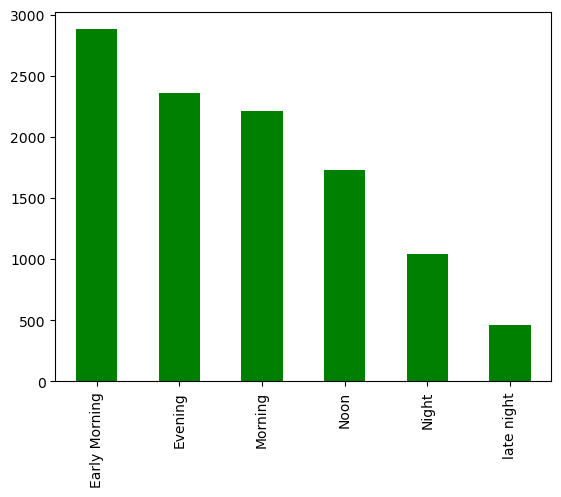

In [18]:
# Classifying the flight departure into time-period categories
# Static plot
train_df['Dep_Time_hour'].apply(flight_dep_time).value_counts().plot(kind="bar" , color="g")

In [22]:
# (Interactive) Plotting flight departure categories
train_df['Dep_Time_hour'].apply(flight_dep_time).value_counts().iplot(kind="bar")

In [25]:
# 'Duration' feature engineering
train_df['Duration'] = train_df['Duration'].apply(preprocess_duration)
train_df['Duration']

0        2h 50m
1        7h 25m
2        19h 0m
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680     3h 0m
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10682, dtype: object

In [26]:
train_df['Duration_hours'] = train_df['Duration'].apply(lambda x : int(x.split(' ')[0][0:-1]))
train_df['Duration_mins'] = train_df['Duration'].apply(lambda x : int(x.split(' ')[1][0:-1]))
train_df

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30,5,25
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2h 30m,non-stop,No info,4107,4,9,2019,19,55,22,25,2,30
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2h 35m,non-stop,No info,4145,27,4,2019,20,45,23,20,2,35
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,3h 0m,non-stop,No info,7229,27,4,2019,8,20,11,20,3,0
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2h 40m,non-stop,No info,12648,3,1,2019,11,30,14,10,2,40


In [ ]:
train_df["Duration_hour"] = pd.to_timedelta(train_df["Duration"]).dt.components.hours
train_df["Duration_minute"] = pd.to_timedelta(train_df["Duration"]).dt.components.minutes